In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163M/163M [00:19<00:00, 8.96MB/s]

Extracting files...


Path to dataset files: /home/wahab/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [3]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torch.optim import Adam
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device used is {device}')

The device used is cpu


In [4]:
images = []
labels = []

for label in os.listdir(f'{path}/data'):
    for image in os.listdir(os.path.join(f'{path}/data', label)):
        images.append(os.path.join(f'{path}/data', label, image))
        labels.append(label)

data = pd.DataFrame({
    'images': images,
    'labels': labels
})
print(f'{len(data)} images found')

7553 images found


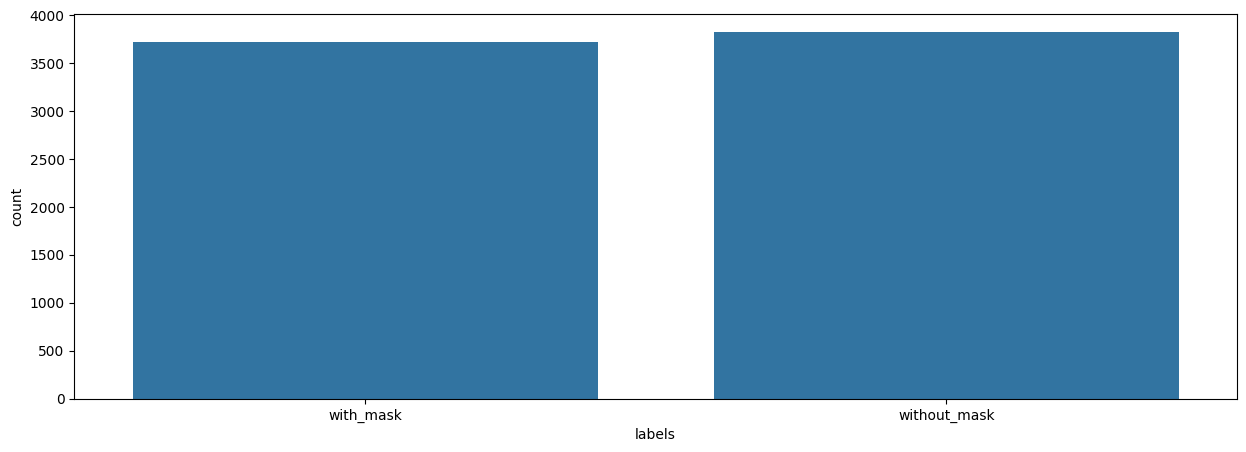

In [5]:
fig = plt.figure(figsize = (15, 5))
sns.countplot(data = data, x = 'labels')
plt.show()

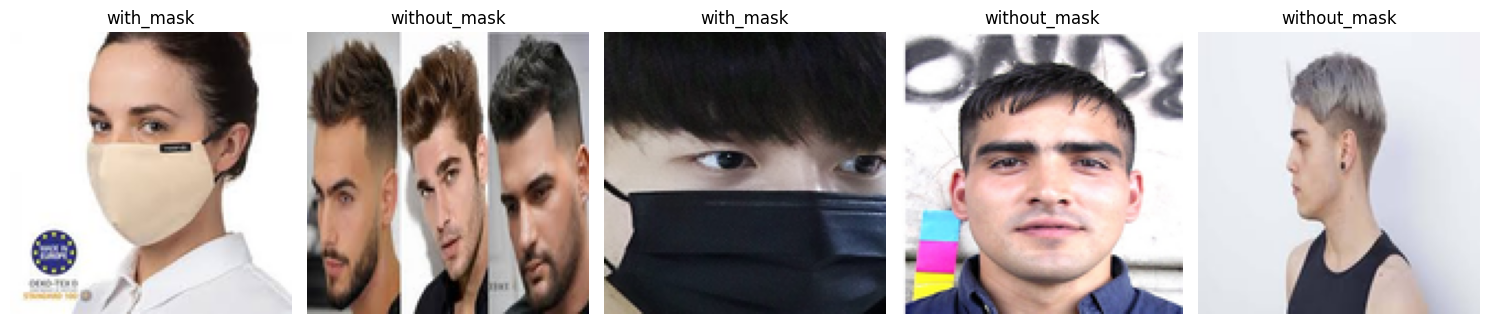

In [5]:
def visualize_sample(n = 5):
    sample = data.sample(n = n)
    fig, axes = plt.subplots(nrows = 1, ncols = n, figsize = (15, 5))

    for ax, (index, row) in zip(axes, sample.iterrows()):
        image = Image.open(row['images'])
        image = image.resize((128, 128), Image.Resampling.LANCZOS)
        label = row['labels']

        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample(n = 5)

In [6]:
train = data.sample(frac = 0.7, random_state = 42)
test = data.drop(train.index)

val = test.sample(frac = 0.5, random_state = 42)
test = test.drop(val.index)

print(f'Train shape : {len(train)}')
print(f'Val shape : {len(val)}')
print(f'Test shape : {len(test)}')

Train shape : 5287
Val shape : 1133
Test shape : 1133


In [7]:
encoder = LabelEncoder()
encoder.fit(data['labels'])
print(f'{encoder.classes_}')

# Transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionne les images à 128x128
    transforms.ToTensor(),  # Convertit les images en Tensor
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),  # Normalisation
    transforms.ConvertImageDtype(torch.float32)  # Convertit en float32 (optionnel ici)
])

['with_mask' 'without_mask']


In [8]:
class MaskFacialDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.labels = torch.tensor(encoder.transform(data['labels'])).to(device)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data.iloc[index, 0]
        label = self.data.iloc[index, 1]
        label = encoder.transform([label])[0]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
training_dataset = MaskFacialDataset(data = train, transform = transform)
validation_dataset = MaskFacialDataset(data = val, transform = transform)
testing_dataset = MaskFacialDataset(data = test, transform = transform)

In [10]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [12]:
train_loader = DataLoader(training_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(testing_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [13]:
class MaskFacialClassifier(nn.Module):
    def __init__(self):
        super(MaskFacialClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1, stride = 1)

        self.pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear = nn.Linear(in_features = 128 * 16 * 16, out_features = 128)
        self.output = nn.Linear(in_features = 128, out_features = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        output = torch.sigmoid(x)
        return output

In [14]:
model = MaskFacialClassifier().to(device)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
---------------------------

In [15]:
train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        total_train_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()

        predicted = (outputs >= 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss_epoch = total_train_loss / total_train
    train_accuracy_epoch = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * inputs.size(0)

            predicted = (outputs >= 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss_epoch = total_val_loss / total_val
    val_accuracy_epoch = correct_val / total_val

    train_loss.append(round(train_loss_epoch, 4))
    train_accuracy.append(round(train_accuracy_epoch, 4))
    val_loss.append(round(val_loss_epoch, 4))
    val_accuracy.append(round(val_accuracy_epoch, 4))

    print(f'Epoch : {epoch + 1}/{EPOCHS} | Train Loss : {train_loss[-1]} | Train Accuracy : {train_accuracy[-1]} | Val Loss : {val_loss[-1]} | Val Accuracy : {val_accuracy[-1]}')

Epoch : 1/10 | Train Loss : 0.3267 | Train Accuracy : 0.8549 | Val Loss : 0.2936 | Val Accuracy : 0.8773
Epoch : 2/10 | Train Loss : 0.233 | Train Accuracy : 0.9047 | Val Loss : 0.2471 | Val Accuracy : 0.895
Epoch : 3/10 | Train Loss : 0.1895 | Train Accuracy : 0.9289 | Val Loss : 0.2442 | Val Accuracy : 0.8959
Epoch : 4/10 | Train Loss : 0.1568 | Train Accuracy : 0.9406 | Val Loss : 0.1961 | Val Accuracy : 0.9188
Epoch : 5/10 | Train Loss : 0.1264 | Train Accuracy : 0.9531 | Val Loss : 0.194 | Val Accuracy : 0.9276
Epoch : 6/10 | Train Loss : 0.0962 | Train Accuracy : 0.9654 | Val Loss : 0.1951 | Val Accuracy : 0.9241
Epoch : 7/10 | Train Loss : 0.0755 | Train Accuracy : 0.9756 | Val Loss : 0.2014 | Val Accuracy : 0.9241
Epoch : 8/10 | Train Loss : 0.0556 | Train Accuracy : 0.98 | Val Loss : 0.1914 | Val Accuracy : 0.9391
Epoch : 9/10 | Train Loss : 0.0414 | Train Accuracy : 0.9871 | Val Loss : 0.1774 | Val Accuracy : 0.9373
Epoch : 10/10 | Train Loss : 0.0291 | Train Accuracy : 0.989

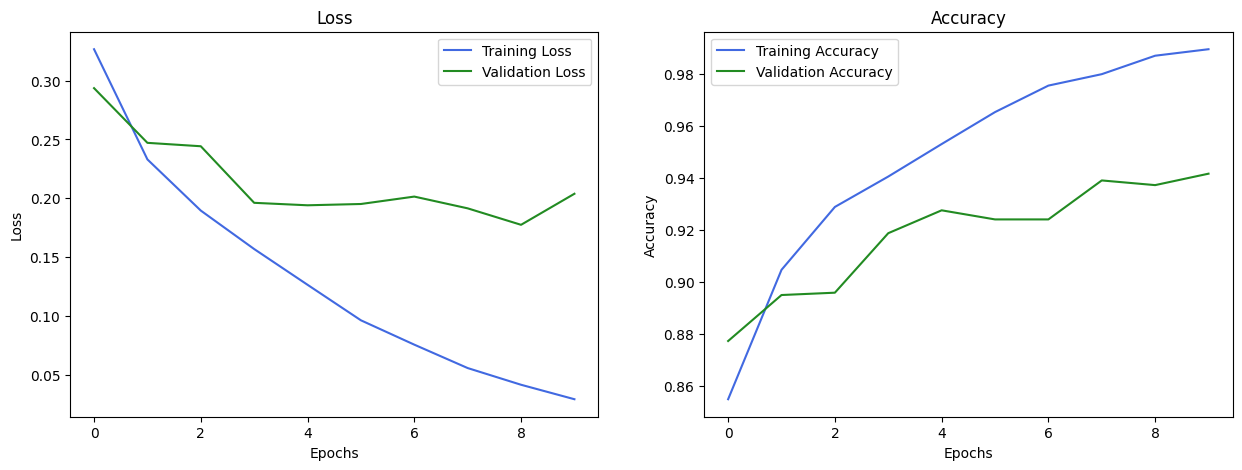

In [16]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axes[0].plot(train_loss, color = 'royalblue', label = 'Training Loss')
axes[0].plot(val_loss, color = 'forestgreen', label = 'Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(train_accuracy, color = 'royalblue', label = 'Training Accuracy')
axes[1].plot(val_accuracy, color = 'forestgreen', label = 'Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

In [17]:
model.eval()
total_test_loss = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * inputs.size(0)

        predicted = (outputs >= 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_loss = total_test_loss / total_test
test_accuracy = correct_test / total_test

print(f'Test Loss : {round(test_loss, 4)} | Test Accuracy : {round(test_accuracy, 4)}')

Test Loss : 0.1694 | Test Accuracy : 0.947


Classification Report :
              precision    recall  f1-score   support

    Classe 0       0.93      0.96      0.95       549
    Classe 1       0.96      0.93      0.95       584

    accuracy                           0.95      1133
   macro avg       0.95      0.95      0.95      1133
weighted avg       0.95      0.95      0.95      1133



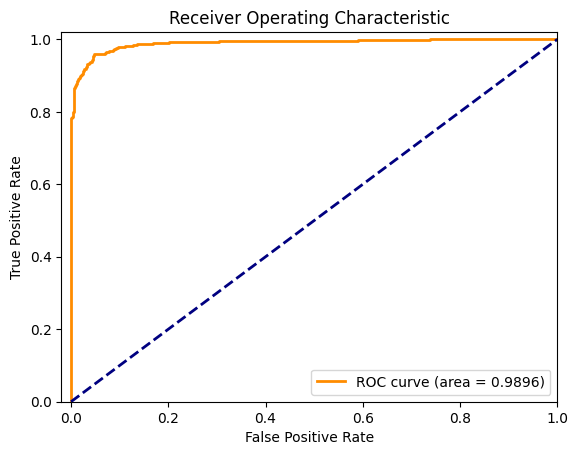

In [18]:
model.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)  # déjà sigmoid en sortie
        probs = outputs.squeeze()  # ou outputs.flatten()
        preds = (probs >= 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=['Classe 0', 'Classe 1'])
print('Classification Report :')
print(report)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")

plt.show()

In [19]:
def predict(image_path):
    image = Image.open(image_path).convert('RGB')

    # 2. Prétraitement
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 3. Prédiction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob = output.squeeze()
        prediction = (prob >= 0.5).float()

    predicted_class = encoder.classes_[int(prediction.item())]

    plt.imshow(image)
    plt.title(f'{predicted_class}')
    plt.axis('off')
    plt.show()

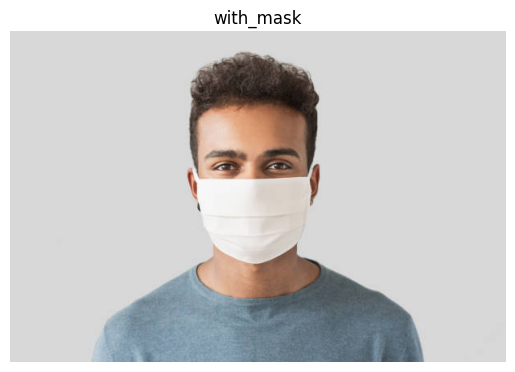

In [20]:
predict('images/person_with_mask.jpg')

In [22]:
import joblib
joblib.dump(encoder.classes_, 'models/classes.pkl')
torch.save(model.state_dict(), 'models/mask_face_detection.pth')